[I 2025-04-29 00:24:53,540] A new study created in memory with name: no-name-183642a6-33c7-493e-9cda-462de14278fd
[I 2025-04-29 00:25:09,572] Trial 0 finished with value: 0.9574279022417229 and parameters: {'n_layers': 3, 'width': 95, 'dropout_rate': 0.14793255612134104}. Best is trial 0 with value: 0.9574279022417229.
[I 2025-04-29 00:25:25,899] Trial 1 finished with value: 1.2911656193577128 and parameters: {'n_layers': 6, 'width': 119, 'dropout_rate': 0.04061372010838996}. Best is trial 1 with value: 1.2911656193577128.
[I 2025-04-29 00:25:41,932] Trial 2 finished with value: 0.8497682282152448 and parameters: {'n_layers': 4, 'width': 91, 'dropout_rate': 0.10924368685996012}. Best is trial 1 with value: 1.2911656193577128.
[I 2025-04-29 00:25:57,520] Trial 3 finished with value: 0.7527458679266755 and parameters: {'n_layers': 3, 'width': 86, 'dropout_rate': 0.06816323468933887}. Best is trial 1 with value: 1.2911656193577128.
[I 2025-04-29 00:26:13,452] Trial 4 finished with value: 

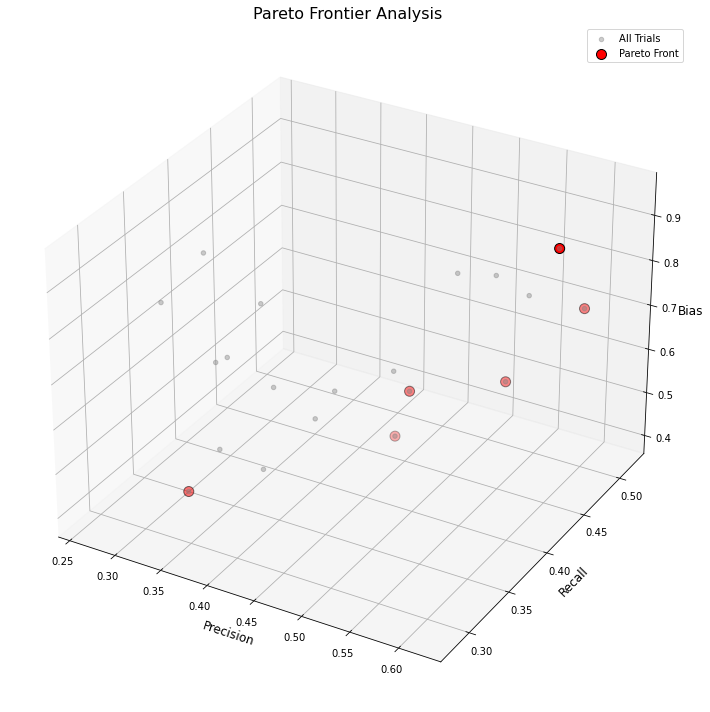

In [4]:
import os
import numpy as np
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv
import gc

# Basic settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Define transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Reduced from 224 to save memory
    transforms.ToTensor(),
])

# Load datasets
train_dataset = ImageFolder(root="2/Training", transform=transform)
test_dataset = ImageFolder(root="2/Testing", transform=transform)

# Split training into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

batch_size = 16  # Reduced from 32 to save memory
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(train_dataset.classes)

# Memory-efficient Model Definition
class CustomResNet(nn.Module):
    def __init__(self, n_layers, width, dropout_rate, num_classes):
        super(CustomResNet, self).__init__()
        self.features = self._make_layers(n_layers, width, dropout_rate)
        self.classifier = nn.Linear(width, num_classes)
    
    def _make_layers(self, n_layers, width, dropout_rate):
        layers = []
        in_channels = 3
        
        # Initial downsampling
        layers.extend([
            nn.Conv2d(in_channels, width//4, kernel_size=3, padding=1),
            nn.BatchNorm2d(width//4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        ])
        in_channels = width//4
        
        for i in range(n_layers):
            layers.extend([
                nn.Conv2d(in_channels, width, kernel_size=3, padding=1),
                nn.BatchNorm2d(width),
                nn.ReLU(inplace=True),
            ])
            
            # Add pooling every 2 layers
            if (i + 1) % 2 == 0:
                layers.append(nn.MaxPool2d(2, 2))
                
            layers.append(nn.Dropout2d(p=dropout_rate))
            in_channels = width
        
        # Final adaptive pooling
        layers.append(nn.AdaptiveAvgPool2d((1, 1)))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Metrics
def calculate_metrics(y_true, y_pred, num_classes):
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    label_counts = cm.sum(axis=0)
    bias = np.std(label_counts) / (np.mean(label_counts) + 1e-6)
    return precision, recall, bias

def cleanup():
    torch.cuda.empty_cache()
    gc.collect()

# Objective function with memory management
def objective(trial):
    try:
        # Conservative hyperparameter ranges
        n_layers = trial.suggest_int('n_layers', 2, 6)  # Reduced range
        width = trial.suggest_int('width', 32, 128)     # Reduced width
        dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.3)
        
        model = CustomResNet(n_layers, width, dropout_rate, num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        best_val_score = -np.inf
        patience = 2
        no_improve = 0
        
        for epoch in range(3):  # Reduced epochs
            model.train()
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
            
            # Validation
            model.eval()
            val_preds, val_labels = [], []
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    preds = outputs.argmax(dim=1)
                    val_preds.append(preds.cpu().numpy())
                    val_labels.append(targets.cpu().numpy())
            
            val_preds = np.concatenate(val_preds)
            val_labels = np.concatenate(val_labels)
            precision, recall, bias = calculate_metrics(val_labels, val_preds, num_classes)
            current_score = precision + recall - bias
            
            if current_score > best_val_score:
                best_val_score = current_score
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    break
        
        # Clean up before next trial
        del model, optimizer
        cleanup()
        
        return best_val_score
    
    except RuntimeError as e:
        if 'CUDA out of memory' in str(e):
            print(f"Pruning trial due to OOM: {str(e)[:200]}...")
            cleanup()
            raise optuna.exceptions.TrialPruned()
        cleanup()
        raise

# Optimize with TPESampler which is more memory efficient
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=20, gc_after_trial=True)

# Collect results
results = []
for trial in study.trials:
    if trial.state == optuna.trial.TrialState.COMPLETE and trial.value is not None:
        params = trial.params
        model = CustomResNet(**params, num_classes=num_classes).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()
        
        # Train final model
        for epoch in range(5):
            model.train()
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
        
        # Evaluate
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                preds = outputs.argmax(dim=1)
                all_preds.append(preds.cpu().numpy())
                all_labels.append(targets.cpu().numpy())
        
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        precision, recall, bias = calculate_metrics(all_labels, all_preds, num_classes)
        
        results.append((
            params['n_layers'],
            params['width'],
            params['dropout_rate'],
            precision,
            recall,
            bias
        ))
        
        del model, optimizer
        cleanup()

# Save results
if results:
    with open('pareto_all.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['n_layers', 'width', 'dropout', 'precision', 'recall', 'bias'])
        writer.writerows(results)

    # Get Pareto frontier
    def get_pareto_frontier(results):
        frontier = []
        for candidate in results:
            dominated = False
            for other in results:
                if (other[3] >= candidate[3] and  # precision
                    other[4] >= candidate[4] and  # recall
                    other[5] <= candidate[5] and   # bias
                    (other[3] > candidate[3] or 
                     other[4] > candidate[4] or 
                     other[5] < candidate[5])):
                    dominated = True
                    break
            if not dominated:
                frontier.append(candidate)
        return sorted(frontier, key=lambda x: (-x[3], -x[4], x[5]))

    pareto_front = get_pareto_frontier(results)
    
    with open('pareto_front.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['n_layers', 'width', 'dropout', 'precision', 'recall', 'bias'])
        writer.writerows(pareto_front)

    # Visualization
    if pareto_front:
        fig = plt.figure(figsize=(14, 10))
        ax = fig.add_subplot(111, projection='3d')

        # Plot all points
        all_prec = [r[3] for r in results]
        all_rec = [r[4] for r in results]
        all_bias = [r[5] for r in results]
        ax.scatter(all_prec, all_rec, all_bias, c='grey', alpha=0.4, label='All Trials')

        # Plot Pareto front
        front_prec = [r[3] for r in pareto_front]
        front_rec = [r[4] for r in pareto_front]
        front_bias = [r[5] for r in pareto_front]
        ax.scatter(front_prec, front_rec, front_bias, c='red', s=100, 
                  edgecolors='black', label='Pareto Front')

        ax.set_xlabel('Precision', fontsize=12)
        ax.set_ylabel('Recall', fontsize=12)
        ax.set_zlabel('Bias', fontsize=12)
        plt.title('Pareto Frontier Analysis', fontsize=16)
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("No Pareto frontier points found - all points were dominated")
else:
    print("No successful trials completed - all trials were pruned or failed")